# Optimal Savings II: Alternative Algorithms

-----

#### John Stachurski

#### Prepared for the CBC Workshop (May 2024)

-----

In `opt_savings_1.ipynb` we solved a simple version of the household optimal
savings problem via value function iteration (VFI) using JAX.

In this lecture we tackle exactly the same problem while adding in two
alternative algorithms:

* optimistic policy iteration (OPI) and
* Howard policy iteration (HPI).

We will see that both of these algorithms outperform traditional VFI.

One reason for this is that the algorithms have good convergence properties.

Another is that one of them, HPI, is particularly well suited to pairing with
JAX.

The reason is that HPI uses a relatively small number of computationally expensive steps,
whereas VFI uses a longer sequence of small steps.

In other words, VFI is inherently more sequential than HPI, and sequential
routines are hard to parallelize.

By comparison, HPI is less sequential -- the small number of computationally
intensive steps can be effectively parallelized by JAX.

This is particularly valuable when the underlying hardware includes a GPU.

Details on VFI, HPI and OPI can be found in [this book](https://dp.quantecon.org), for which a PDF is freely available.

Here we assume readers have some knowledge of the algorithms and focus on
computation.


----

Uncomment if necessary:

In [1]:
#!pip install quantecon

We will use the following imports:

In [2]:
import quantecon as qe
import jax
import jax.numpy as jnp
from collections import namedtuple
import matplotlib.pyplot as plt
import time

Let's check the GPU we are running.

In [3]:
!nvidia-smi

Fri May 10 15:20:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:3E:00.0 Off |                  N/A |
| 30%   31C    P8             26W /  320W |       9MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/home/john/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


We'll use 64 bit floats to gain extra precision.

In [4]:
jax.config.update("jax_enable_x64", True)

## Model primitives

We start with a namedtuple to store parameters and arrays

In [5]:
Model = namedtuple('Model', ('β', 'R', 'γ', 'w_grid', 'y_grid', 'Q'))

The following code is repeated from `opt_savings_1`.

In [6]:
def create_consumption_model(R=1.01,                    # Gross interest rate
                             β=0.98,                    # Discount factor
                             γ=2,                       # CRRA parameter
                             w_min=0.01,                # Min wealth
                             w_max=5.0,                 # Max wealth
                             w_size=150,                # Grid size
                             ρ=0.9, ν=0.1, y_size=100): # Income parameters
    """
    A function that takes in parameters and returns parameters and grids 
    for the optimal savings problem.
    """
    w_grid = jnp.linspace(w_min, w_max, w_size)
    mc = qe.tauchen(n=y_size, rho=ρ, sigma=ν)
    y_grid, Q = jnp.exp(mc.state_values), jax.device_put(mc.P)
    return Model(β, R, γ, w_grid, y_grid, Q)

Here's the right hand side of the Bellman equation:

In [7]:
def _B(v, model, i, j, ip):
    """
    The right-hand side of the Bellman equation before maximization, which takes
    the form

        B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)

    The indices are (i, j, ip) -> (w, y, w′).
    """
    β, R, γ, w_grid, y_grid, Q = model
    w, y, wp  = w_grid[i], y_grid[j], w_grid[ip]
    c = R * w + y - wp
    EV = jnp.sum(v[ip, :] * Q[j, :]) 
    return jnp.where(c > 0, c**(1-γ)/(1-γ) + β * EV, -jnp.inf)

Now we successively apply `vmap` to vectorize $B$ by simulating nested loops.

In [8]:
B_vmap = jax.vmap(_B,      in_axes=(None, None, None, None, 0))
B_vmap = jax.vmap(B_vmap, in_axes=(None, None, None, 0,    None))
B_vmap = jax.vmap(B_vmap, in_axes=(None, None, 0,    None, None))

Here's a fully vectorized version of $B$.

In [9]:
@jax.jit
def B(v, model):
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    return B_vmap(v, model, w_indices, y_indices, w_indices)

## Operators


Here's the Bellman operator $T$

In [10]:
@jax.jit
def T(v, model):
    "The Bellman operator."
    return jnp.max(B(v, model), axis=-1)

The next function computes a $v$-greedy policy given $v$

In [11]:
@jax.jit
def get_greedy(v, modeld):
    "Computes a v-greedy policy, returned as a set of indices."
    return jnp.argmax(B(v, model), axis=-1)

We define a function to compute the current rewards $r_\sigma$ given policy $\sigma$,
which is defined as the vector

$$
    r_\sigma(w, y) := r(w, y, \sigma(w, y)) 
$$

In [12]:
def _compute_r_σ(σ, model, i, j):
    """
    With indices (i, j) -> (w, y) and wp = σ[i, j], compute 
        
        r_σ[i, j] = u(Rw + y - wp)   

    which gives current rewards under policy σ.
    """

    # Unpack model
    β, R, γ, w_grid, y_grid, Q = model
    # Compute r_σ[i, j]
    w, y, wp = w_grid[i], y_grid[j], w_grid[σ[i, j]]
    c = R * w + y - wp
    r_σ = c**(1-γ)/(1-γ)

    return r_σ

Now we successively apply `vmap` to simulate nested loops.

In [13]:
compute_r_σ_vmap = jax.vmap(_compute_r_σ,     in_axes=(None, None, None, 0))
compute_r_σ_vmap = jax.vmap(compute_r_σ_vmap, in_axes=(None, None, 0,    None))

Here's a fully vectorized version of $r_\sigma$.

In [14]:
@jax.jit
def compute_r_σ(σ, model):
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    return compute_r_σ_vmap(σ, model, w_indices, y_indices)

Now we define the policy operator $T_\sigma$ going through similar steps

In [15]:
def _T_σ(v, σ, model, i, j):
    "The σ-policy operator."

    # Unpack model
    β, R, γ, w_grid, y_grid, Q = model

    r_σ  = _compute_r_σ(σ, model, i, j)
    # Calculate the expected sum Σ_jp v[σ[i, j], jp] * Q[i, j, jp]
    EV = jnp.sum(v[σ[i, j], :] * Q[j, :])

    return r_σ + β * EV


T_σ_vmap = jax.vmap(_T_σ,     in_axes=(None, None, None, None, 0))
T_σ_vmap = jax.vmap(T_σ_vmap, in_axes=(None, None, None, 0,    None))


@jax.jit
def T_σ(v, σ, model):
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    return T_σ_vmap(v, σ, model, w_indices, y_indices)

The function below computes the value $v_\sigma$ of following policy $\sigma$.

This lifetime value is a function $v_\sigma$ that satisfies

$$
v_\sigma(w, y) = r_\sigma(w, y) + \beta \sum_{y'} v_\sigma(\sigma(w, y), y') Q(y, y')
$$

We wish to solve this equation for $v_\sigma$.

Suppose we define the linear operator $L_\sigma$ by

$$ 
(L_\sigma v)(w, y) = v(w, y) - \beta \sum_{y'} v(\sigma(w, y), y') Q(y, y')
$$

With this notation, the problem is to solve for $v$ via

$$
(L_{\sigma} v)(w, y) = r_\sigma(w, y)
$$

In vector for this is $L_\sigma v = r_\sigma$, which tells us that the function
we seek is

$$ 
v_\sigma = L_\sigma^{-1} r_\sigma 
$$

JAX allows us to solve linear systems defined in terms of operators; the first
step is to define the function $L_{\sigma}$.

In [16]:
def _L_σ(v, σ, model, i, j):
    """
    Here we set up the linear map v -> L_σ v, where 

        (L_σ v)(w, y) = v(w, y) - β Σ_y′ v(σ(w, y), y′) Q(y, y′)

    """
    # Unpack
    β, R, γ, w_grid, y_grid, Q = model
    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Q[j, jp]
    return v[i, j]  - β * jnp.sum(v[σ[i, j], :] * Q[j, :])

L_σ_vmap = jax.vmap(_L_σ,     in_axes=(None, None, None, None, 0))
L_σ_vmap = jax.vmap(L_σ_vmap, in_axes=(None, None, None, 0,    None))

@jax.jit
def L_σ(v, σ, model):
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    return L_σ_vmap(v, σ, model, w_indices, y_indices)

Now we can define a function to compute $v_{\sigma}$

In [17]:
@jax.jit
def get_value(σ, model):
    "Get the value v_σ of policy σ by inverting the linear map L_σ."

    r_σ = compute_r_σ(σ, model)
    partial_L_σ = lambda v: L_σ(v, σ, model)
    return jax.scipy.sparse.linalg.bicgstab(partial_L_σ, r_σ)[0]

## Iteration


We use successive approximation for VFI.

In [18]:
def successive_approx_jax(T,                     # Operator (callable)
                          x_0,                   # Initial condition                
                          tol=1e-6,              # Error tolerance
                          max_iter=10_000):      # Max iteration bound
    def update(inputs):
        k, x, error = inputs
        x_new = T(x)
        error = jnp.max(jnp.abs(x_new - x))
        return k + 1, x_new, error

    def condition_function(inputs):
        k, x, error = inputs
        return jnp.logical_and(error > tol, k < max_iter)

    k, x, error = jax.lax.while_loop(condition_function, 
                                     update, 
                                     (1, x_0, tol + 1))
    return x

successive_approx_jax = jax.jit(successive_approx_jax, static_argnums=(0,))

For OPI we'll add a compiled routine that computes $T_σ^m v$.

In [19]:
@jax.jit
def iterate_policy_operator(σ, v, m, model):

    def update(i, v):
        v = T_σ(v, σ, model)
        return v
    
    v = jax.lax.fori_loop(0, m, update, v)
    return v



## Solvers

Now we define the solvers, which implement VFI, HPI and OPI.

Here's VFI.

In [20]:
def value_function_iteration(model, tol=1e-4):
    """
    Implements value function iteration.
    """
    β, R, γ, w_grid, y_grid, Q = model
    sizes = len(w_grid), len(y_grid)
    vz = jnp.zeros(sizes)
    _T = lambda v: T(v, model)
    v_star = successive_approx_jax(_T, vz, tol=tol)
    return get_greedy(v_star, model)

For OPI we will use a compiled JAX `lax.while_loop` operation to speed execution.

In [21]:
def opi_loop(model, m, tol, max_iter):
    """
    Implements optimistic policy iteration (see dp.quantecon.org) with 
    step size m.

    """
    β, R, γ, w_grid, y_grid, Q = model
    sizes = len(w_grid), len(y_grid)
    v_init = jnp.zeros(sizes)

    def condition_function(inputs):
        i, v, error = inputs
        return jnp.logical_and(error > tol, i < max_iter)

    def update(inputs):
        i, v, error = inputs
        last_v = v
        σ = get_greedy(v, model)
        v = iterate_policy_operator(σ, v, m, model)
        error = jnp.max(jnp.abs(v - last_v))
        i += 1
        return i, v, error

    num_iter, v, error = jax.lax.while_loop(condition_function,
                                            update,
                                            (0, v_init, tol + 1))

    return get_greedy(v, model)

opi_loop = jax.jit(opi_loop, static_argnums=(1,))

Here's a friendly interface to OPI

In [22]:
def optimistic_policy_iteration(model, m=10, tol=1e-4, max_iter=10_000):
    σ_star = opi_loop(model, m, tol, max_iter)
    return σ_star

Here's HPI.

In [23]:
def howard_policy_iteration(model, tol=1e-4, maxiter=250):
    """
    Implements Howard policy iteration (see dp.quantecon.org)
    """
    β, R, γ, w_grid, y_grid, Q = model
    sizes = len(w_grid), len(y_grid)
    v_σ = jnp.zeros(sizes)
    i, error = 0, 1.0
    while error > tol and i < maxiter:
        σ = get_greedy(v_σ, model)
        v_σ_new = get_value(σ, model)
        error = jnp.max(jnp.abs(v_σ_new - v_σ))
        v_σ = v_σ_new
        i = i + 1
        print(f"Concluded loop {i} with error {error}.")
    return σ

## Plots

Create a model for consumption, perform policy iteration, and plot the resulting optimal policy function.

In [24]:
model = create_consumption_model()
β, R, γ, w_grid, y_grid, Q = model

Concluded loop 1 with error 58.057814844603136.
Concluded loop 2 with error 3.048231827690195.
Concluded loop 3 with error 1.8430762677072394.
Concluded loop 4 with error 1.2226486858397578.
Concluded loop 5 with error 0.50185384807763.
Concluded loop 6 with error 0.12063608435527584.
Concluded loop 7 with error 0.01380189058068737.
Concluded loop 8 with error 0.0006069507737862523.
Concluded loop 9 with error 5.241054093829689e-05.


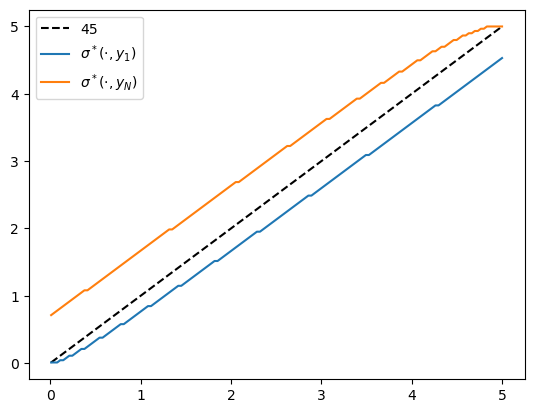

In [25]:
σ_star = howard_policy_iteration(model)

fig, ax = plt.subplots()
ax.plot(w_grid, w_grid, "k--", label="45")
ax.plot(w_grid, w_grid[σ_star[:, 1]], label="$\\sigma^*(\cdot, y_1)$")
ax.plot(w_grid, w_grid[σ_star[:, -1]], label="$\\sigma^*(\cdot, y_N)$")
ax.legend()
plt.show()

## Tests

Let's create an instance of the model.

In [26]:
model = create_consumption_model()

Here's a function that runs any one of the algorithms and returns the result and
elapsed time.

In [27]:
def run_algorithm(algorithm, model, **kwargs):
    start_time = time.time()
    result = algorithm(model, **kwargs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{algorithm.__name__} completed in {elapsed_time:.2f} seconds.")
    return result, elapsed_time

Here's a quick test of each model.

HPI first run:

In [28]:
σ_pi, pi_time = run_algorithm(howard_policy_iteration, 
                              model)

Concluded loop 1 with error 58.057814844603136.
Concluded loop 2 with error 3.048231827690195.
Concluded loop 3 with error 1.8430762677072394.
Concluded loop 4 with error 1.2226486858397578.
Concluded loop 5 with error 0.50185384807763.
Concluded loop 6 with error 0.12063608435527584.
Concluded loop 7 with error 0.01380189058068737.
Concluded loop 8 with error 0.0006069507737862523.
Concluded loop 9 with error 5.241054093829689e-05.
howard_policy_iteration completed in 0.05 seconds.


HPI second run:

In [29]:
σ_pi, pi_time = run_algorithm(howard_policy_iteration, 
                              model)

Concluded loop 1 with error 58.057814844603136.
Concluded loop 2 with error 3.048231827690195.
Concluded loop 3 with error 1.8430762677072394.
Concluded loop 4 with error 1.2226486858397578.
Concluded loop 5 with error 0.50185384807763.
Concluded loop 6 with error 0.12063608435527584.
Concluded loop 7 with error 0.01380189058068737.
Concluded loop 8 with error 0.0006069507737862523.
Concluded loop 9 with error 5.241054093829689e-05.
howard_policy_iteration completed in 0.05 seconds.


VFI first run:

In [30]:
print("Starting VFI.")
σ_vfi, vfi_time = run_algorithm(value_function_iteration, 
                                model, tol=1e-4)

Starting VFI.
value_function_iteration completed in 0.22 seconds.


VFI second run:

In [31]:
print("Starting VFI.")
σ_vfi, vfi_time = run_algorithm(value_function_iteration, 
                                model, tol=1e-4)

Starting VFI.
value_function_iteration completed in 0.17 seconds.


OPI first run:

In [32]:
m = 100
print(f"Starting OPI with $m = {m}$.")
σ_opi, opi_time = run_algorithm(optimistic_policy_iteration, 
                                model, m=m, tol=1e-4)

Starting OPI with $m = 100$.
optimistic_policy_iteration completed in 0.29 seconds.


OPI second run:

In [33]:
m = 100
print(f"Starting OPI with $m = {m}$.")
σ_opi, opi_time = run_algorithm(optimistic_policy_iteration, 
                                model, m=m, tol=1e-4)

Starting OPI with $m = 100$.
optimistic_policy_iteration completed in 0.05 seconds.


Now let's run OPI at a range of $m$ values and plot the execution time along
side the execution time for VFI and HPI.

In [34]:
σ_pi, pi_time = run_algorithm(howard_policy_iteration, model)
σ_vfi, vfi_time = run_algorithm(value_function_iteration, model, tol=1e-4)
m_vals = range(5, 600, 40)
opi_times = []
for m in m_vals:
    σ_opi, opi_time = run_algorithm(optimistic_policy_iteration, 
                                    model, m=m, tol=1e-4)
    opi_times.append(opi_time)

Concluded loop 1 with error 58.057814844603136.
Concluded loop 2 with error 3.048231827690195.
Concluded loop 3 with error 1.8430762677072394.
Concluded loop 4 with error 1.2226486858397578.
Concluded loop 5 with error 0.50185384807763.
Concluded loop 6 with error 0.12063608435527584.
Concluded loop 7 with error 0.01380189058068737.
Concluded loop 8 with error 0.0006069507737862523.
Concluded loop 9 with error 5.241054093829689e-05.
howard_policy_iteration completed in 0.05 seconds.
value_function_iteration completed in 0.17 seconds.
optimistic_policy_iteration completed in 0.27 seconds.
optimistic_policy_iteration completed in 0.26 seconds.
optimistic_policy_iteration completed in 0.27 seconds.
optimistic_policy_iteration completed in 0.28 seconds.
optimistic_policy_iteration completed in 0.29 seconds.
optimistic_policy_iteration completed in 0.31 seconds.
optimistic_policy_iteration completed in 0.34 seconds.
optimistic_policy_iteration completed in 0.34 seconds.
optimistic_policy_it

Here's the plot.

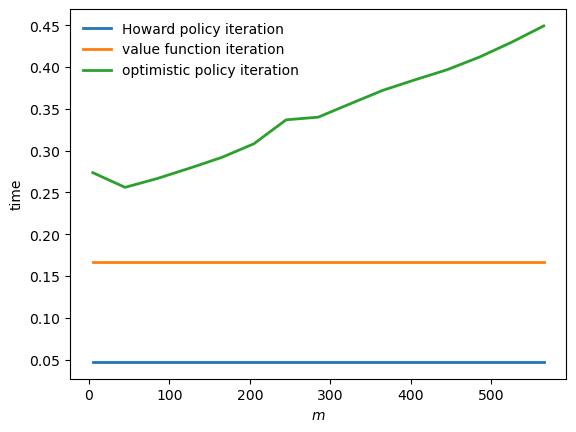

In [35]:
fig, ax = plt.subplots()
ax.plot(m_vals, 
        jnp.full(len(m_vals), pi_time), 
        lw=2, label="Howard policy iteration")
ax.plot(m_vals, 
        jnp.full(len(m_vals), vfi_time), 
        lw=2, label="value function iteration")
ax.plot(m_vals, opi_times, 
        lw=2, label="optimistic policy iteration")
ax.legend(frameon=False)
ax.set_xlabel("$m$")
ax.set_ylabel("time")
plt.show()